In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def load_train_data():
    train_file = 'train.json.zip'
    train = pd.read_json(train_file, orient='records', convert_dates=['created'])
    train.reset_index(drop=True, inplace=True)
    return train

def load_test_data():
    test_file = 'test.json.zip'
    test = pd.read_json(test_file, orient='records', convert_dates=['created'])
    test.reset_index(drop=True, inplace=True)
    return test


In [32]:
# load train data
train = load_train_data()
# test = load_test_data()

# remove outliers
# latitude
lower = np.percentile(train['latitude'].values, 1)
upper = np.percentile(train['latitude'].values, 99)
train = train[train['latitude'] > lower]
train = train[train['latitude'] < upper]
# train.latitude.hist()

# longitude
lower = np.percentile(train['longitude'].values, 1)
upper = np.percentile(train['longitude'].values, 99)
train = train[train['longitude'] > lower]
train = train[train['longitude'] < upper]
# train.longitude.hist()

# price
upper = np.percentile(train['price'].values, 99)
train = train[train['price'] < upper]
# train.price.hist()

train.reset_index(drop=True, inplace=True)

In [6]:
train['photo_number'] = len(train['photos'])
train['location'] = train[['latitude', 'longitude']].values.tolist()
train['target'] = train['interest_level'].apply(lambda x: 0 if x=='low' else 1 if x=='medium' else 2)

# finding all features
features_dict = {}
def get_features(features):
    for f in features:
        f = f.strip('!')
        f = f.strip('*')
        f = f.strip(' ')
        
        if f in features_dict.keys():
            features_dict[f] += 1
        else:
            features_dict[f] = 1
            
temp = train['features'].apply(get_features)
features_dict.keys()

feature_columns = {}
feature_list = []
for key in features_dict.keys():
    if features_dict[key] >= 20000:
        feature_list.append(key)
        feature_columns[key] = []
        
def get_feature_columns(features):
    for key in feature_columns:
        if key in features:
            feature_columns[key].append(True)
        else:
            feature_columns[key].append(False)
            
temp = train['features'].apply(get_feature_columns)
train = pd.concat([train, pd.DataFrame.from_dict(feature_columns)], axis=1)


# using external dataset
subway = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')
subway = subway[['Station Name', 'Station Latitude', 'Station Longitude']]
subway = subway.groupby(['Station Name']).mean().reset_index(drop=True)

from math import cos, asin, sqrt
# https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula/21623206
def distance_pair(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 +  cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    d_2_point = 6371 *2 * asin(sqrt(a)) #2*R*asin...
    return d_2_point
distance_pairs = np.vectorize(distance_pair)

def get_nearby_subway(location):
    distances = distance_pairs(location[0], location[1], subway['Station Latitude'], subway['Station Longitude'])    
    return distances[distances < 1].shape[0]
    
def get_subway_distance(location):
    distances = distance_pairs(location[0], location[1], subway['Station Latitude'], subway['Station Longitude'])    
    return min(distances)


train['nearby_subway'] = train['location'].apply(get_nearby_subway)
train['subway_distance'] = train['location'].apply(get_subway_distance)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = train[['bathrooms', 'bedrooms', 'photo_number', 'nearby_subway', 'subway_distance', 'price'] + feature_list]
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# logistic_model.fit(X_train, y_train)
# print(logistic_model.score(X_train, y_train))
# print(logistic_model.score(X_test, y_test))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logistic_model, X, y, cv=5)
print("Accuracy: %f (+/- %f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.699179 (+/- 0.000110)


# Display all building on NYC map

In [11]:
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon


In [33]:
def get_geometry(data):
    crs = {'init': 'epsg:4326'}
    geometry=[Point(xy)for xy in zip(data['longitude'], data['latitude'])]
    geo_df = gpd.GeoDataFrame(data,
                            crs = crs,
                            geometry = geometry)
    geo_df.reset_index(inplace=True)
    return geo_df

#Process the input data
train_geo = get_geometry(train)
# train.head()

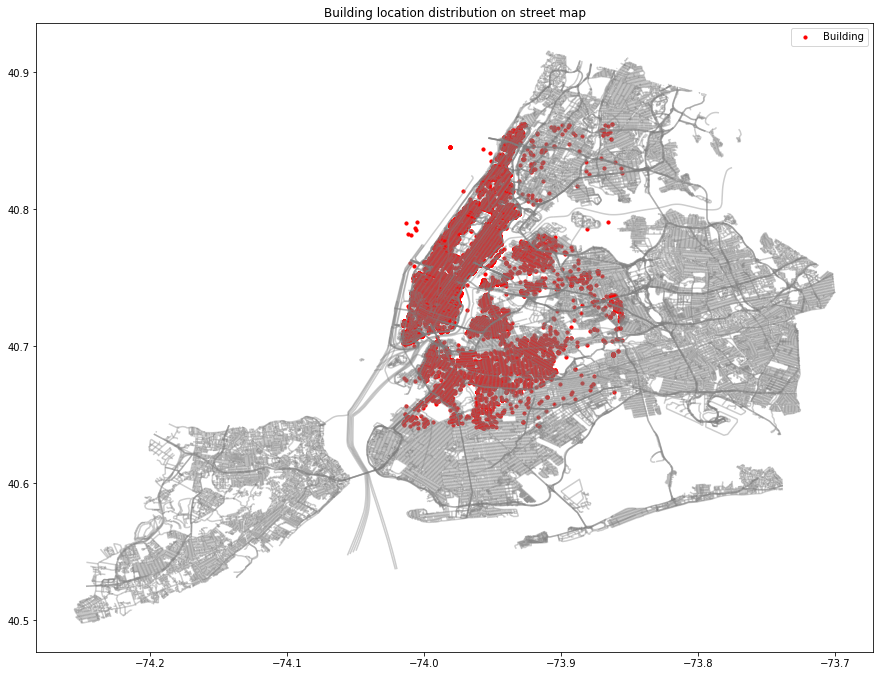

In [34]:
# displays on street map
map_street = gpd.read_file('NYC_street_map.shp')
fig, ax = plt.subplots(figsize = (15,15))
map_street.plot(ax=ax, alpha=0.4, color="grey", edgecolor = 'k')
train_geo.plot(ax=ax, markersize=10, color='red', marker='o', label='Building')
plt.title('Building location distribution on street map')
plt.legend()
plt.show()

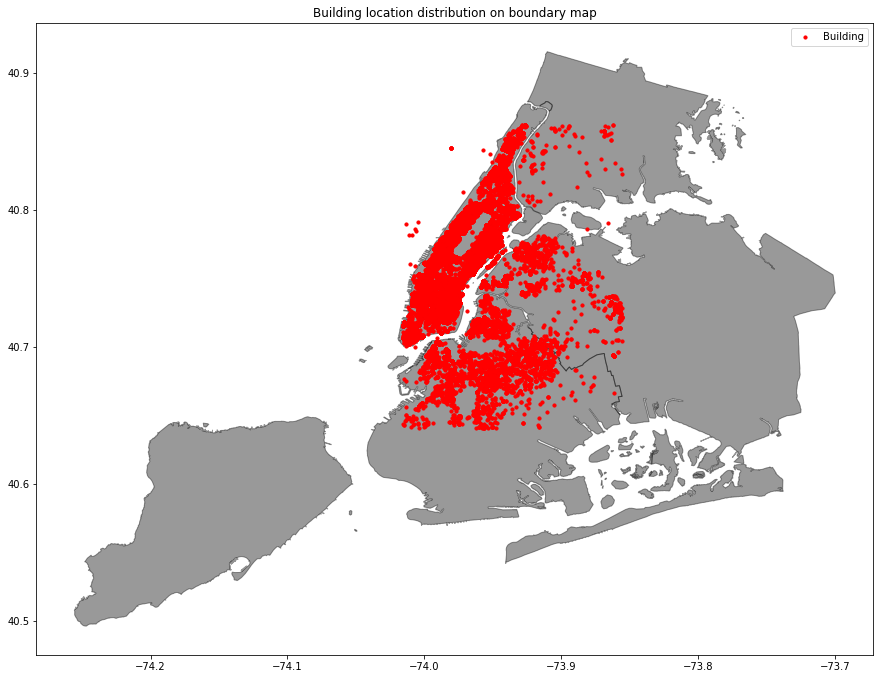

In [35]:
# displays on city boundary map
map_boundary = gpd.read_file('NYC_boundary.shp')
fig, ax = plt.subplots(figsize = (15,15))
map_boundary.plot(ax=ax, alpha=0.4, color='black', edgecolor='k')
train_geo.plot(ax=ax, markersize=10, color='red', marker='o', label='Building')
plt.title('Building location distribution on boundary map')
plt.legend()
plt.show()


In [37]:
nyc = map_boundary['geometry'].unary_union

In [38]:
# https://stackoverflow.com/questions/52600811/using-geopandas-how-do-i-select-all-points-not-within-a-polygon
# train_geo[train_geo['geometry'].within(nyc)]
nyc

# NYC Map

In [ ]:
# pip3 install shapely==1.5.17.post1
# pip3 install geopandas==0.2.1
# pip3 install geojsonio==0.0.3

In [ ]:
NYC = gpd.read_file('NYC.geojson')

In [ ]:
NYC.head()

In [ ]:
NYC = NYC.to_json()